In [1]:
import pandas as pd
import numpy as np
from ProgSnap2 import ProgSnap2Dataset
from ProgSnap2 import PS2
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import os
from os import path

In [2]:
train_semester = 'S19'
test_semester = 'F19'
BASE_PATH = os.path.join('data', 'Release', train_semester)
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')
TEST_PATH = os.path.join('data', 'Release', test_semester, 'Test')

if test_semester == 'F19':
    phase = 'Phase1' if train_semester == 'S19' else 'Phase2'
else:
    phase = 'Practice' if train_semester == 'F19' else 'Backwards'
phase

'Phase1'

In [3]:
train_ps2 = ProgSnap2Dataset(os.path.join(TRAIN_PATH, 'Data')) 

In [4]:
# The early dataset will help us to feature extraction,
# but we're not actually predicting anything here
# Note: we could still use this for model training if desired.
early_train = pd.read_csv(os.path.join(TRAIN_PATH, 'early.csv'))
early_train.head()

,SubjectID,AssignmentID,ProblemID,Attempts,CorrectEventually,Label
0,04c32d4d95425f73b3a1d6502aed4d48,439.0,1,1,True,True
1,04c32d4d95425f73b3a1d6502aed4d48,439.0,3,2,True,True
2,04c32d4d95425f73b3a1d6502aed4d48,439.0,5,3,True,True
3,04c32d4d95425f73b3a1d6502aed4d48,439.0,12,1,True,True
4,04c32d4d95425f73b3a1d6502aed4d48,439.0,13,2,True,True


In [5]:
# The late dataset contains the problems that we're actually predicting for.
# The training portion of it includes labels.
late_train = pd.read_csv(os.path.join(TRAIN_PATH, 'late.csv'))
late_train.head()

,SubjectID,AssignmentID,ProblemID,Label
0,04c32d4d95425f73b3a1d6502aed4d48,494.0,41,False
1,04c32d4d95425f73b3a1d6502aed4d48,494.0,43,True
2,04c32d4d95425f73b3a1d6502aed4d48,494.0,44,True
3,04c32d4d95425f73b3a1d6502aed4d48,494.0,46,True
4,04c32d4d95425f73b3a1d6502aed4d48,494.0,49,True


In [6]:
X_train_base = late_train.copy().drop('Label', axis=1)
y_train = late_train['Label'].values

In [7]:
problem_encoder = OneHotEncoder().fit(X_train_base[PS2.ProblemID].values.reshape(-1, 1))

In [8]:
problem_encoder.transform(X_train_base[PS2.ProblemID].values.reshape(-1, 1)).toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [9]:
def get_code_table(ps2_dataset):
    events_table = ps2_dataset.get_main_table()
    code_states = ps2_dataset.get_code_states_table()
    runs = events_table.merge(code_states, on=PS2.CodeStateID)
    runs = runs[runs[PS2.EventType] == 'Run.Program']
    runs = runs[[PS2.Order, PS2.SubjectID, PS2.ProblemID, 'Code']]
    return runs

In [10]:
code_table_train = get_code_table(train_ps2)
code_table_train

,Order,SubjectID,ProblemID,Code
0,119441,04c32d4d95425f73b3a1d6502aed4d48,1,"public int sortaSum(int a, int b)\r\n{\r\n ..."
2,134115,04c32d4d95425f73b3a1d6502aed4d48,3,"public boolean in1To10(int n, boolean outsideM..."
4,134117,04c32d4d95425f73b3a1d6502aed4d48,3,"public boolean in1To10(int n, boolean outsideM..."
6,65403,04c32d4d95425f73b3a1d6502aed4d48,5,"public boolean answerCell(boolean isMorning, b..."
10,65407,04c32d4d95425f73b3a1d6502aed4d48,5,"public boolean answerCell(boolean isMorning, b..."
...,...,...,...,...
134497,113478,ffb72475a81de0e95b910ffad039f5c2,70,public boolean twoTwo(int[] nums)\r\n{\r\n ...
134500,113483,ffb72475a81de0e95b910ffad039f5c2,70,public boolean twoTwo(int[] nums)\r\n{\r\n ...
134502,108282,ffb72475a81de0e95b910ffad039f5c2,71,public boolean canBalance(int[] nums)\r\n{\r\n...
134504,110202,ffb72475a81de0e95b910ffad039f5c2,112,public int[] seriesUp(int n)\r\n{\r\n int[]...


In [11]:
# Some empty strings got imported as "NaN", so we turn them bcak
code_table_train['Code'][code_table_train['Code'].apply(lambda x: not isinstance(x, str))] = ""

In [12]:
# We want to find a consistent, common vocabulary across all problems
# so we first build our vocabulary for all code submissions

from sklearn.feature_extraction.text import TfidfVectorizer

# Note this approach is _very_ naive, since it's using NLP assumptions
# about tokenizing, among other things, but it is good enough for a demonstration.
code_vectorizer = TfidfVectorizer(max_features=30)
code_vectorizer.fit(code_table_train['Code'])
top_vocab = code_vectorizer.vocabulary_
top_vocab

{'public': 19,
 'int': 14,
 'if': 13,
 '10': 0,
 'return': 21,
 'else': 7,
 'boolean': 3,
 'true': 28,
 'false': 10,
 'speed': 23,
 'string': 25,
 'day': 6,
 '21': 1,
 'str': 24,
 'substring': 26,
 'length': 15,
 'num': 17,
 'small': 22,
 'big': 2,
 'goal': 12,
 'for': 11,
 'end': 8,
 'equals': 9,
 'word': 29,
 'new': 16,
 'count': 5,
 'charat': 4,
 'nums': 18,
 'sum': 27,
 'result': 20}

In [13]:
# We want to create a separate encoder for each problem, since the
# "document frequency" part of TF-IDF should be calibrated separately
# for each problem.
code_problem_encoders = {}
def create_encoder(rows):
    code = rows['Code']
    problem_id = rows[PS2.ProblemID].iloc[0]
    code_vectorizer = TfidfVectorizer(vocabulary=top_vocab)
    code_vectorizer.fit(code)
    code_problem_encoders[problem_id] = code_vectorizer
    
code_table_train.groupby(PS2.ProblemID).apply(create_encoder)
len(code_problem_encoders)

50

In [14]:
test_code = code_table_train['Code'].iloc[0]
print(test_code)
print(code_problem_encoders[1].transform([test_code]))

public int sortaSum(int a, int b)
{
    if (a + b >= 10)
    {
        if (a + b <= 19)
        {
            return 20;
        }
        return a + b;
    }
    else
    {
        return a + b;
    }
}

  (0, 21)	0.5929619322827931
  (0, 19)	0.19320378937452193
  (0, 14)	0.5796113681235658
  (0, 13)	0.39681148818701084
  (0, 7)	0.2744965584355051
  (0, 0)	0.20569731847202877


In [15]:
def extract_instance_features(instance, early_df):
    instance = instance.copy()
    subject_id = instance[PS2.SubjectID]
    early_problems = early_df[early_df[PS2.SubjectID] == subject_id]
    # Extract very naive features about the student
    # (without respect to the problem bring predicted)
    # Number of early problems attempted
    instance['ProblemsAttempted'] = early_problems.shape[0]
    # Percentage of early problems gotten correct eventually
    instance['PercCorrectEventually'] = np.mean(early_problems['CorrectEventually'])
    # Median attempts made on early problems
    instance['MedAttempts'] = np.median(early_problems['Attempts'])
    # Max attempts made on early problems
    instance['MaxAttempts'] = np.max(early_problems['Attempts'])
    # Percentage of problems gotten correct on the first try
    instance['PercCorrectFirstTry'] = np.mean(early_problems['Attempts'] == 1)
    
    instance = instance.drop('SubjectID')
    return instance

In [16]:
extract_instance_features(X_train_base.iloc[0], early_train)

AssignmentID                  494
ProblemID                      41
ProblemsAttempted              30
PercCorrectEventually           1
MedAttempts                   6.5
MaxAttempts                    45
PercCorrectFirstTry      0.166667
Name: 0, dtype: object

In [17]:
def extract_instance_code_features(instance, early_df, code_table):
    subject_id = instance[PS2.SubjectID]
    problem_id = instance[PS2.ProblemID]
    
    # Get all attempts for this problem by this subject
    attempts = code_table[(code_table[PS2.SubjectID] == subject_id) & \
                          (code_table[PS2.ProblemID] == problem_id)]
    # Get the code of the last attempt (we could use others but don't here)
    encoder = code_problem_encoders[problem_id]
    # If for some reason there were no attempts, return 0s
    if (attempts.shape[0] == 0):
        return encoder.transform([""])
    last_attempt = attempts.sort_values('Order')['Code'].iloc[-1]
    code_features = encoder.transform([last_attempt])
    
    return code_features

In [18]:
print(extract_instance_code_features(X_train_base.iloc[0], early_train, code_table_train))

  (0, 21)	0.22116095645566827
  (0, 19)	0.2128142305637896
  (0, 18)	0.8512569222551584
  (0, 14)	0.4256284611275792


In [19]:
# Test how to stack code features across instances
from scipy.sparse import vstack
import functools

code_features = X_train_base.iloc[:5].apply(\
    lambda instance: extract_instance_code_features(\
        instance, early_train, code_table_train), axis=1)

vstack(code_features)

<5x30 sparse matrix of type '<class 'numpy.float64'>'
	with 37 stored elements in Compressed Sparse Row format>

In [20]:
def extract_features(X, early_df, code_table, scaler, is_train):
    # First extract performance features for each row
    features = X.apply(lambda instance: extract_instance_features(instance, early_df), axis=1)
    # Then get code features
    code_features = X.apply(lambda instance: extract_instance_code_features(\
            instance, early_df, code_table), axis=1)
    code_features = vstack(code_features).toarray()
    
    # Then one-hot encode the problem_id and append it
    problem_ids = problem_encoder.transform(features[PS2.ProblemID].values.reshape(-1, 1)).toarray()
    # Then get rid of nominal features
    features.drop([PS2.AssignmentID, PS2.ProblemID], axis=1, inplace=True)
    # Then scale the continuous features, fitting the scaler if this is training
    if is_train:
        scaler.fit(features)
    features = scaler.transform(features)
    
    # Return continuous and one-hot features together
    return np.concatenate([features, code_features, problem_ids], axis=1)

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = extract_features(X_train_base, early_train, code_table_train, scaler, True)

In [22]:
print(X_train.shape)
X_train[:2,]

(4201, 55)


array([[ 0.51751812,  0.58371895,  1.76922077,  1.70602676, -0.89569333,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.42562846,
         0.        ,  0.        ,  0.        ,  0.85125692,  0.21281423,
         0.        ,  0.22116096,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.51751812,  0.58371895,  1.76922077,  1.70602676, -0.89569333,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.26622699,  0.

## Evaluate the Training Performance of the Model

In [23]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# We set an alpha value; otherwise the model overfits with 100% accuracy
# If we were being rigorous, we would set this using hyperparameter tuning
model = RandomForestClassifier(ccp_alpha=0.001)
model.fit(X_train, y_train)
train_predictions = model.predict(X_train)

In [24]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

print(classification_report(train_predictions, y_train))
print('AUC: ' + str(roc_auc_score(train_predictions, y_train)))
print('Macro F1: ' + str(f1_score(train_predictions, y_train, average='macro')))

              precision    recall  f1-score   support

       False       0.40      0.89      0.55       488
        True       0.98      0.83      0.90      3713

    accuracy                           0.83      4201
   macro avg       0.69      0.86      0.73      4201
weighted avg       0.92      0.83      0.86      4201

AUC: 0.8594603365225415
Macro F1: 0.7261091800505926


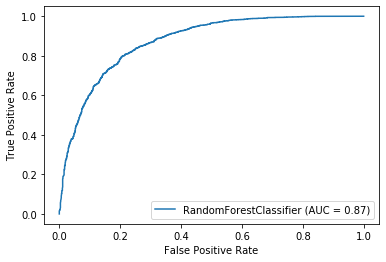

In [25]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(model, X_train, y_train)

In [26]:
# Look at which features were important
print(np.argsort(model.feature_importances_))
model.feature_importances_

[ 6 17  9 28 11 31 34  7 29 42 48 45 39 41 53 38 27 14 36 40 46 54 43 49
 50 22 35 52 30 44 51 25 47 13 10 37  5 32 15 33  8 21 12  0 23 16 18 19
 26 20  3 24  1  2  4]


array([2.27452388e-02, 1.26339632e-01, 1.43070805e-01, 8.04346305e-02,
       1.61453894e-01, 7.14297828e-03, 0.00000000e+00, 3.50209229e-05,
       1.62533246e-02, 0.00000000e+00, 5.60574319e-03, 0.00000000e+00,
       2.08958561e-02, 4.06843076e-03, 1.18901210e-03, 1.18756640e-02,
       3.30729412e-02, 0.00000000e+00, 3.30875175e-02, 4.06352458e-02,
       4.57384490e-02, 2.02048888e-02, 2.50386736e-03, 2.60496695e-02,
       8.07311217e-02, 3.75800611e-03, 4.49010079e-02, 1.14484523e-03,
       0.00000000e+00, 5.27344510e-04, 2.84091552e-03, 0.00000000e+00,
       8.70384788e-03, 1.55748085e-02, 0.00000000e+00, 2.62453184e-03,
       1.22866304e-03, 6.81356715e-03, 9.41735687e-04, 7.80726613e-04,
       1.43899213e-03, 7.80744677e-04, 5.56115937e-04, 1.76004995e-03,
       3.21304501e-03, 7.23409213e-04, 1.43943197e-03, 3.84170007e-03,
       7.01061712e-04, 1.77755755e-03, 2.16471239e-03, 3.52591345e-03,
       2.70982905e-03, 8.10506623e-04, 1.58299896e-03])

In [27]:
# The first 7 featurs are from attempts.
# The top-4 most important are from these.
extract_instance_features(X_train_base.iloc[0], early_train).index

Index(['AssignmentID', 'ProblemID', 'ProblemsAttempted',
       'PercCorrectEventually', 'MedAttempts', 'MaxAttempts',
       'PercCorrectFirstTry'],
      dtype='object')

In [28]:
# The next 30 features come from the vocbulary, and the next 20 are the test problem ID
sorted(top_vocab)

['10',
 '21',
 'big',
 'boolean',
 'charat',
 'count',
 'day',
 'else',
 'end',
 'equals',
 'false',
 'for',
 'goal',
 'if',
 'int',
 'length',
 'new',
 'num',
 'nums',
 'public',
 'result',
 'return',
 'small',
 'speed',
 'str',
 'string',
 'substring',
 'sum',
 'true',
 'word']

In [29]:
# The 5th highest importance feature is #24
# The variable name num
print(sorted(top_vocab)[24 - 7])
# public, perhaps used if declaring a helper method
print(sorted(top_vocab)[26 - 7])
# The variable name goal
print(sorted(top_vocab)[19 - 7])
# if
print(sorted(top_vocab)[20 - 7])
# for
print(sorted(top_vocab)[18 - 7])

num
public
goal
if
for


## Evaluate the CV Performance of the Model

In [30]:
from sklearn.model_selection import cross_validate

model = RandomForestClassifier(ccp_alpha=0.001)
cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=['accuracy', 'f1_macro', 'roc_auc'])
print(f'Accuracy: {np.mean(cv_results["test_accuracy"])}')
print(f'AUC: {np.mean(cv_results["test_roc_auc"])}')
print(f'Macro F1: {np.mean(cv_results["test_f1_macro"])}')

Accuracy: 0.7655279995470246
AUC: 0.7763003254345441
Macro F1: 0.6069877464423336


## Predict on the test data

In [31]:
early_test = pd.read_csv(os.path.join(TEST_PATH, 'early.csv'))
late_test = pd.read_csv(os.path.join(TEST_PATH, 'late.csv'))

test_ps2 = ProgSnap2Dataset(os.path.join(TEST_PATH, 'Data'))
code_table_test = get_code_table(test_ps2)

X_test = extract_features(late_test, early_test, code_table_test, scaler, False)

In [32]:
X_test.shape

(2365, 55)

In [33]:
model = RandomForestClassifier(ccp_alpha=0.001)
model.fit(X_train, y_train)
predictions = model.predict_proba(X_test)[:,1]

In [34]:
predictions

array([0.5685999 , 0.56731575, 0.57733766, ..., 0.56555255, 0.54475783,
       0.55409728])

In [35]:
predictions_df = late_test.copy()
predictions_df['Label'] = predictions
predictions_df

,SubjectID,AssignmentID,ProblemID,Label
0,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,41,0.568600
1,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,43,0.567316
2,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,44,0.577338
3,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,46,0.566946
4,00358c94503a8d9e6869efc6e5cdb0e1c8e9eb39b1fd46...,494,49,0.559975
...,...,...,...,...
2360,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,64,0.576655
2361,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,70,0.527736
2362,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,71,0.565553
2363,fa7805c1d46ef49851de43750a665a993eef750b560159...,502,112,0.544758


In [36]:
# We don't have the test labels - you have to submit to evaluate it

In [37]:
# We use res/predictions.csv, since that's where the scoring rogram expects it
# but you can change this directory
path = os.path.join('data', 'Prediction', phase, 'code_RF_task1', 'res')
os.makedirs(path, exist_ok=True)
predictions_df.to_csv(os.path.join(path, 'predictions.csv'), index=False)